# 2023/24-XAI-LABS
Note that this lab has three levels: basic, regular and advanced.\
Doing the **basic** part earns you a grade of 5.5-6.0.\
Doing the **regular** part earns you a max grade of 8.\
Doing the **advanced** part earns you a max grade of 10.0.

Please return a Jupyter notebook as a submission in Canvas, to make the grading easier for us.

**Group No:**

**Student Name**:

**Student Name**:
**Student Name**:

# Lecture 3
The following set of exercises are related to the Lecture 3.
## Adversarial Attack Simulation
Neural Networks are generally not robust and can be fooled easily. You will create adversarial examples using techniques like the Fast Gradient Sign Method (FGSM) and test these against a pretrained model to observe how the predictions change.

### (Basic)Exercise 1
For the basic part of this exercise you can use the starting code from [here](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm). The task is to use a different image and come up with smallest value of epsilon that completely change the prediction of the model.

In [1]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

device = torch.device("cpu")

weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights).to(device)
model = nn.Sequential(model, nn.Softmax(dim=1))
model.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [2]:
from torchvision.io import read_image

img = read_image("Airliner.jpg")

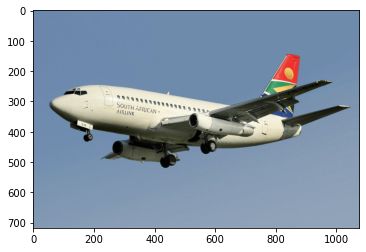

In [3]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1,2,0))

In [4]:
preprocess = weights.transforms()
batch = preprocess(img).unsqueeze(0).to(device)

C:\Users\woutv\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
def denormalize(batch):
    return batch * torch.tensor(preprocess.std).view(1, -1, 1, 1).to(device) + torch.tensor(preprocess.mean).view(1,-1,1,1).to(device)

In [6]:
def normalize(batch):
    return (batch - torch.tensor(preprocess.mean).view(1,-1,1,1).to(device)) / torch.tensor(preprocess.std).view(1, -1, 1, 1).to(device)

In [47]:
def FGSM(model, batch, epsilon, class_names, normalized, show=False):
    batch.requires_grad = True
    
    output = model(batch)
    prediction = output.squeeze(0)
    class_id = prediction.argmax().item()
    
    loss = F.nll_loss(output, torch.tensor([class_id]).to(device))
    model.zero_grad()
    loss.backward()
    
    data_grad = batch.grad.data
    sign_data_grad = data_grad.sign()
    
    if normalized:
        denormalized_batch = denormalize(batch)
        new_batch = denormalized_batch + epsilon * sign_data_grad
    else:
        new_batch = batch + epsilon * sign_data_grad
    
    if show:
        plt.imshow(new_batch.squeeze(0).detach().cpu().permute(1,2,0))
        plt.show()
    
    if normalized:
        normalized_batch = normalize(new_batch)
        prediction = model(normalized_batch).squeeze(0)
    else:
        prediction = model(new_batch).squeeze(0)
    
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = class_names[class_id]
    print(f"Guess: {category_name} {100 * score:.1f}%")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epsilon: 0.3


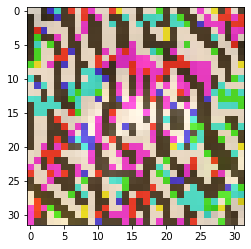

Guess: electric ray 100.0%
Epsilon: 0.15


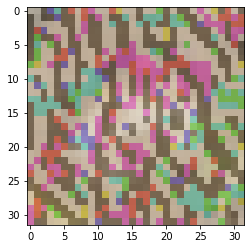

Guess: electric ray 100.0%
Epsilon: 0.1


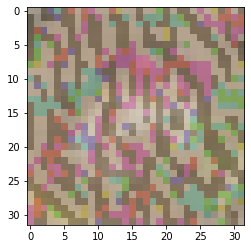

Guess: electric ray 100.0%
Epsilon: 0.05


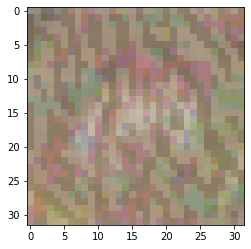

Guess: electric ray 100.0%
Epsilon: 0.01


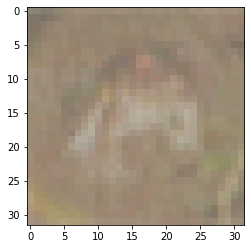

Guess: electric ray 100.0%
Epsilon: 0.005


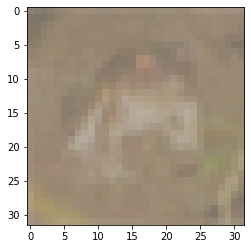

Guess: electric ray 100.0%
Epsilon: 0


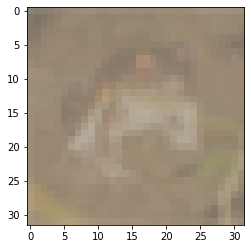

Guess: stingray 100.0%


In [52]:
epsilons = [0.3, 0.15, 0.1, 0.05, 0.01, 0.005, 0]
for epsilon in epsilons:
    print(f"Epsilon: {epsilon}")
    FGSM(model, batch, epsilon, weights.meta["categories"],True, True)

### (Advanced) Exercise 2
Train your own neural network and make it robust against such attack specifically against FGSM.


In [12]:
import wandb

In [9]:
device = torch.device("cuda")

In [21]:
class NeuralNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=4096, out_features=200)
        self.relu7 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=200, out_features=output_channels)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout1(x)
        x = self.maxpool1(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.dropout2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu7(x)
        
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [17]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root='./data', download=True, transform=transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
wandb.init(
    # set the wandb project where this run will be logged
    project="XAI",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": "CIFAR-10",
    "epochs": 25,
    }
)

acc,▁▁▁▁▁▁▄▅▆▆▇▆▆▇▆▇██▇▇▇▆███
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,██████▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
acc,0.48488
epoch,24
loss,1559.96338


In [22]:
model = NeuralNet(3, 10).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 25

# Normal training
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        labels = labels.to(device)
        inputs = inputs.to(device)

        y_pred = model(inputs)
        batch_loss = loss_function(y_pred, labels)
        total_loss += batch_loss
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    model.eval()
    total_correct = 0
    total = 0
    for inputs, labels in test_dataloader:
        labels = labels.to(device)
        inputs = inputs.to(device)

        total_correct += (model(inputs).argmax(1) == labels).sum()
        total += len(labels)

    accuracy = total_correct/total
    wandb.log({"epoch": epoch, "acc": accuracy, "loss": total_loss})

In [23]:
wandb.finish()

acc,▁▂▄▅▅▅▅▆▆▆▇▇██▇█▇▇▆▇█▇▇██
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.69478
epoch,24
loss,1395.74915


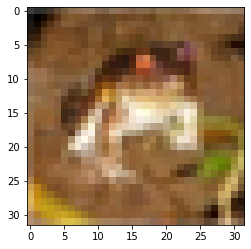

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epsilon: 0.3


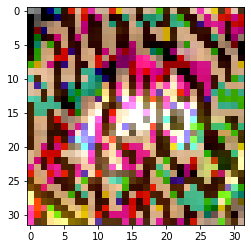

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guess: dog 100.0%
Epsilon: 0.15


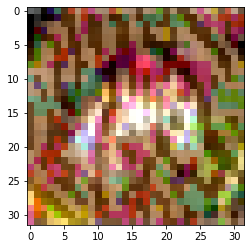

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guess: dog 100.0%
Epsilon: 0.1


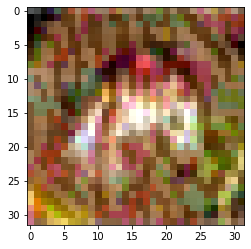

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guess: dog 100.0%
Epsilon: 0.05


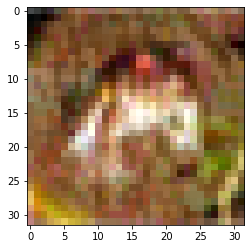

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guess: dog 100.0%
Epsilon: 0.01


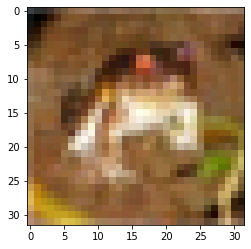

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guess: dog 99.7%
Epsilon: 0.005


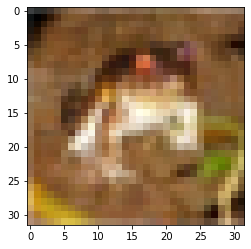

Guess: frog 99.5%
Epsilon: 0


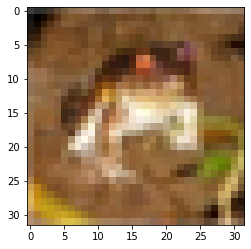

Guess: frog 100.0%


In [63]:
epsilons = [0.3, 0.15, 0.1, 0.05, 0.01, 0.005, 0]
batch = test_data[0][0].unsqueeze(0).to(device)

plt.imshow(batch.squeeze(0).cpu().permute(1,2,0))
plt.show()


for epsilon in epsilons:
    print(f"Epsilon: {epsilon}")
    FGSM(model, batch, epsilon, train_data.classes,False, True)

Using the [art library](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/#) to make adversarial training more convenient

In [67]:
wandb.init(
    # set the wandb project where this run will be logged
    project="XAI",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": "CIFAR-10-FGSM",
    "epochs": 25,
    }
)

In [68]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from tqdm import tqdm

FGSM_model = NeuralNet(3, 10).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(FGSM_model.parameters(), lr=0.001, weight_decay=1e-5)
classifier = PyTorchClassifier(
        model=model,
        clip_values=(0, 1),
        loss=loss_function,
        optimizer=optimizer,
        input_shape=(1, 32, 32),
        nb_classes=100,
    )
attack = FastGradientMethod(estimator=classifier, eps=0.02)

for epoch in tqdm(range(epochs)):
    FGSM_model.train()
    total_loss=0
    for i, (inputs, labels) in enumerate(train_dataloader):
        labels = labels.to(device)

        inputs_adv = attack.generate(x=inputs.numpy())
        inputs = torch.from_numpy(inputs_adv).to(device)

        y_pred = FGSM_model(inputs)
        batch_loss = loss_function(y_pred, labels)
        total_loss += batch_loss
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    FGSM_model.eval()
    total_correct = 0
    total = 0
    for inputs, labels in test_dataloader:
        labels = labels.to(device)
        inputs = inputs.to(device)

        total_correct += (FGSM_model(inputs).argmax(1) == labels).sum()
        total += len(labels)

    accuracy = total_correct/total
    wandb.log({"epoch": epoch, "acc": accuracy, "loss": total_loss})

wandb.finish()

 48%|███████████████████████████████████████▎                                          | 12/25 [15:41<16:59, 78.45s/it]


KeyboardInterrupt: 

In [69]:
wandb.finish()

acc,▁▃▅▄▆▆▇▇▇███
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▅▄▃▃▂▂▂▁▁▁▁
acc,0.62546
epoch,11
loss,1458.08984


In [ ]:
epsilons = [0.3, 0.15, 0.1, 0.05,0.01, 0.005, 0]
batch = test_data[0][0].unsqueeze(0).to(device)

plt.imshow(batch.squeeze(0).cpu().permute(1,2,0))
plt.show()


for epsilon in epsilons:
    print(f"Epsilon: {epsilon}")
    FGSM(model, batch, epsilon, train_data.classes,False, False)

## Compare Pixel Attribution Methods
Apply Saliency Maps, CAM, Grad-CAM, and SmoothGrad to a set of images and analyze the quality of the explanations provided by each method. Write a report discussing the strengths and weaknesses of each technique based on your observations.
### (Basic) Exercise 3
Implement the following techniques, you can use the existing implementaion availabe as a package [ominixai](https://opensource.salesforce.com/OmniXAI/latest/index.html). You are expected to compare the following methods:

- Saliency Maps: Implement a function to compute the saliency map.
- CAM: Implement a function to compute CAM.
- Grad-CAM: Implement a function to compute Grad-CAM.
- SmoothGrad: Implement a function to compute SmoothGrad.

### (Regular) Exercise 4

Create a function to display the original image alongside the saliency map, CAM, Grad-CAM, and SmoothGrad visualizations for comparison.
Display the visualizations for each image.
Analysis

### (Regular) Exercise 5
Compare the results. Some points to look for are:
- Which technique provides the most intuitive explanation.
- The strengths and weaknesses of each technique.
- Any observed differences in the explanations across different images.

## XAI For text Data
## (Advanced) Exercise 6
In this exercise you will work with text data. The only thing you have to do is to follow the steps of this [tuotorial](https://eli5.readthedocs.io/en/latest/tutorials/sklearn-text.html) and apply it to  a different dataset.

## DeepSHAP (DeepLift)


In [ ]:
# imports for a deep learning model
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np

### (Regular)Exercise 7
Use the shap library and the provided starter code to explain the MNIST data set.

In [ ]:
# Train your own NN
# Use Shap
# display result

### (Regular) Exercise 8
Explain what can be understood about the similarity of certain digits as seen by the machine learning model through the explanations.